## Clustering

In [3]:
import numpy as np
import pandas as pd
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from yellowbrick.cluster.elbow import kelbow_visualizer

from lifetimes.utils import summary_data_from_transaction_data

### Read data

In [9]:
data = pd.read_csv('~/Desktop/final data.csv')

In [10]:
data.head()

,STATE,Year,CO2,CH4,N2O,Fluorinated GHG,Incentives,Laws and Regulations,State Incentives,Utility/Private Incentives,Programs,State Hybrid Incentives,Ozone
0,AL,2012,84138381,701702,602778,264437.0,0,3,7,4,0,0,0.044215
1,AL,2013,83297945,594388,451420,274194.0,0,3,7,4,0,0,0.039733
2,AL,2014,84847355,634009,525399,312201.0,0,3,7,4,0,0,0.040936
3,AL,2015,82143007,611595,462661,263031.0,0,3,7,3,0,0,0.039063
4,AL,2016,75103394,550119,528136,302584.0,0,3,6,2,0,0,0.042845


### Data manipulation

Drop columns with more than 70% missing values

In [45]:
data = data.loc[:,(data==0).mean()<0.7]

In [72]:
data['Fluorinated GHG'] = data['Fluorinated GHG'].fillna(0)

Fill missing value with 0

In [73]:
data_model = data.iloc[:,2:]

In [74]:
data_model.head()

,CO2,CH4,N2O,Fluorinated GHG,Laws and Regulations,State Incentives,Utility/Private Incentives,Ozone
0,84138381,701702,602778,264437.0,3,7,4,0.044215
1,83297945,594388,451420,274194.0,3,7,4,0.039733
2,84847355,634009,525399,312201.0,3,7,4,0.040936
3,82143007,611595,462661,263031.0,3,7,3,0.039063
4,75103394,550119,528136,302584.0,3,6,2,0.042845


### Modeling

In [35]:
color = ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]

#### Feature scaling

In [32]:
scaler = StandardScaler().fit(data_model)
data_scaled = scaler.transform(data_model)
data_scaled.std(axis=0)[:7], data_scaled.mean(axis=0)[:7]

(array([1., 1., 1., 1., 1., 1., 1.]),
 array([-4.56777473e-17,  0.00000000e+00, -2.03012210e-17,  0.00000000e+00,
         1.01506105e-16, -8.37425367e-17,  3.04518315e-17]))

#### Dimensionality reduction

In [34]:
pca = PCA()
X_pca = pca.fit_transform(data_scaled)

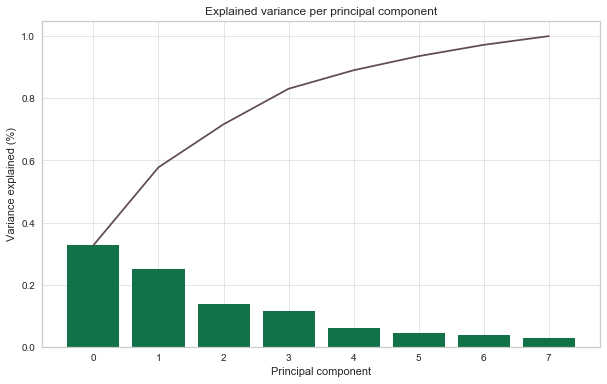

In [36]:
# Scree plot (variance explained by each principal component)
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

plt.figure(figsize=(10,6))

ax = sns.barplot(ind, vals, palette=color[:1], ci=None)
ax2 = sns.lineplot(ind, cumvals, color=color[1], ci=None)
ax.grid(b=True, which='major', linewidth=0.5)

ax.set_xlabel("Principal component")
ax.set_ylabel("Variance explained (%)")
plt.title('Explained variance per principal component');

In [39]:
cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.8])

# rerun PCA with components that explain 80% of the variance
pca = PCA(num_components).fit(data_scaled)
X_pca = pca.transform(data_scaled)
X_pca = pd.DataFrame(X_pca)

np.cumsum(pca.explained_variance_ratio_)

array([0.32698767, 0.57770764, 0.71613558])

### Clustering

#### K-means

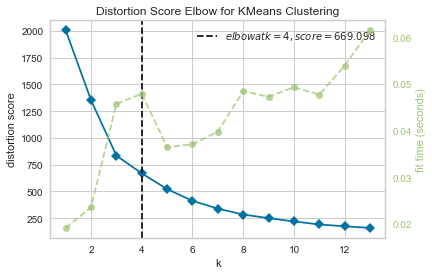

In [40]:
# elbow method
kelbow_visualizer(KMeans(), X_pca, k=(1,14));

In [41]:
model = KMeans(n_clusters=4, random_state=28).fit(X_pca)
kmeans_clusters = model.predict(X_pca)

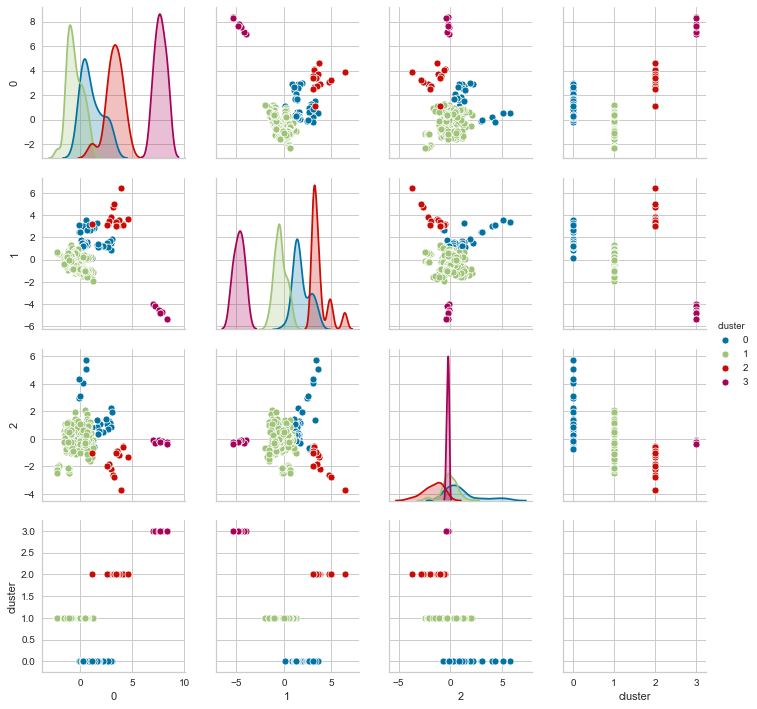

In [44]:
df = X_pca.copy()
df['cluster'] = kmeans_clusters
sns.pairplot(df, hue='cluster')

### Evaluation

In [75]:
df = data.copy().reset_index()
df['cluster'] = kmeans_clusters
df = df.melt(id_vars=['STATE', 'cluster'])
df = df.query('cluster != -1').groupby(['cluster', 'variable']).mean().reset_index()
df.head()

,cluster,variable,value
0,0,CH4,5.742369e+06
1,0,CO2,1.028966e+08
2,0,Fluorinated GHG,1.474850e+06
3,0,Laws and Regulations,1.052381e+01
4,0,N2O,7.482810e+05


In [76]:
indexNames = df[ (df['variable'] == 'Year')| (df['variable'] == 'index')].index
df.drop(indexNames , inplace=True)

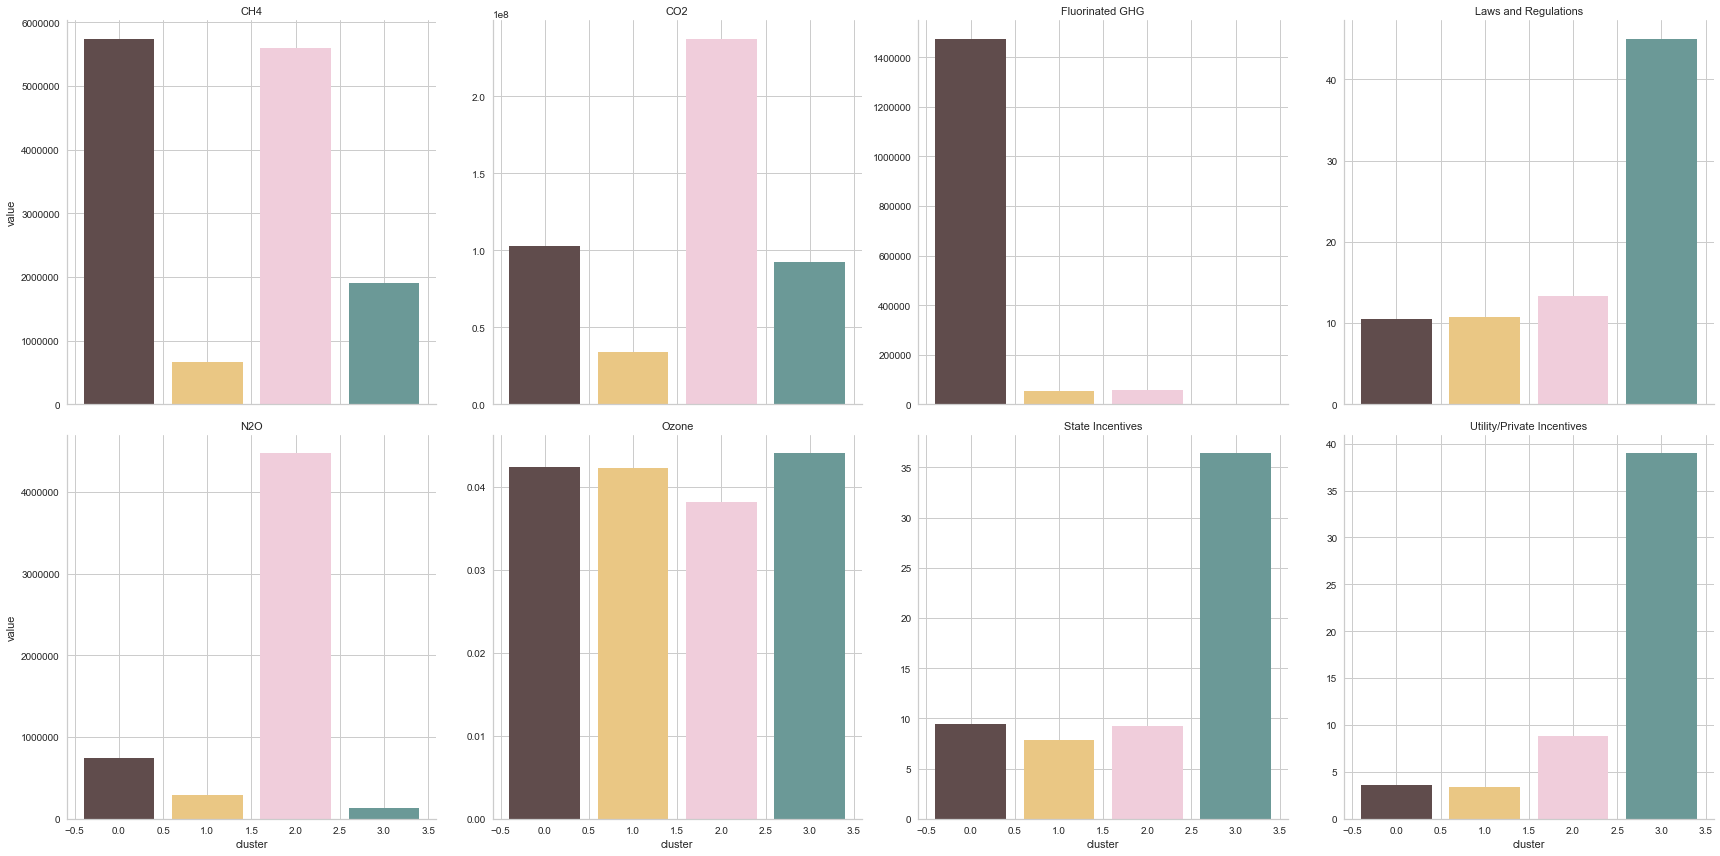

In [77]:
g = sns.FacetGrid(df, col='variable', hue='cluster', palette=color[1:], col_wrap=4, height=6, sharey=False)
g = g.map(plt.bar, 'cluster', 'value').set_titles("{col_name}");

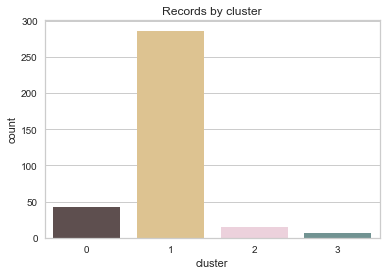

In [78]:
df_1 = data.copy().reset_index()
df_1['cluster'] = kmeans_clusters

ax = sns.countplot(x='cluster', data=df_1,palette=color[1:])
ax.set_title('Records by cluster');

### Heatmap

In [79]:
df_1 = df_1.iloc[:,1:]

In [80]:
df_1.head()

,STATE,Year,CO2,CH4,N2O,Fluorinated GHG,Laws and Regulations,State Incentives,Utility/Private Incentives,Ozone,cluster
0,AL,2012,84138381,701702,602778,264437.0,3,7,4,0.044215,1
1,AL,2013,83297945,594388,451420,274194.0,3,7,4,0.039733,1
2,AL,2014,84847355,634009,525399,312201.0,3,7,4,0.040936,1
3,AL,2015,82143007,611595,462661,263031.0,3,7,3,0.039063,1
4,AL,2016,75103394,550119,528136,302584.0,3,6,2,0.042845,1


In [87]:
heatmap_data = df_1.groupby(['cluster'])[['CO2','CH4','N2O','Fluorinated GHG','Laws and Regulations','State Incentives','Utility/Private Incentives','Ozone']].mean()
heatmap_data = heatmap_data.T
heatmap_data

cluster,0,1,2,3
CO2,1.028966e+08,3.407259e+07,2.374605e+08,9.227830e+07
CH4,5.742369e+06,6.634173e+05,5.594568e+06,1.910732e+06
N2O,7.482810e+05,2.912408e+05,4.473140e+06,1.289083e+05
Fluorinated GHG,1.474850e+06,5.463526e+04,5.690753e+04,0.000000e+00
Laws and Regulations,1.052381e+01,1.080070e+01,1.340000e+01,4.500000e+01
State Incentives,9.476190e+00,7.842657e+00,9.200000e+00,3.642857e+01
Utility/Private Incentives,3.619048e+00,3.346154e+00,8.866667e+00,3.900000e+01
Ozone,4.238673e-02,4.228890e-02,3.819586e-02,4.406893e-02


In [96]:
heatmap_data1 = heatmap_data.iloc[0:3,:]
heatmap_data2 = heatmap_data.iloc[4:6,:]
heatmap_data3 = heatmap_data.iloc[7:8,:]

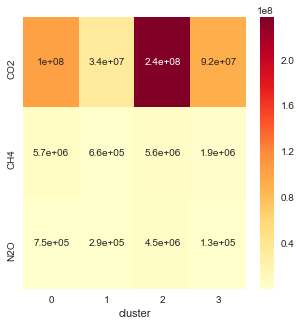

In [90]:
plt.subplots(figsize = (5,5))
fig = sns.heatmap(heatmap_data1,cmap = 'YlOrRd', annot = True)

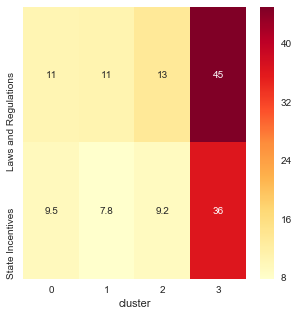

In [94]:
plt.subplots(figsize = (5,5))
fig = sns.heatmap(heatmap_data2,cmap = 'YlOrRd', annot = True)

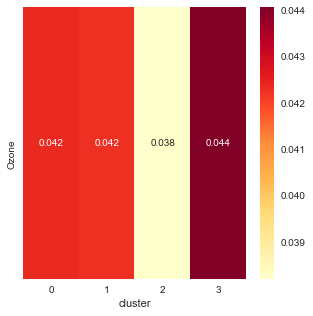

In [97]:
plt.subplots(figsize = (5,5))
fig = sns.heatmap(heatmap_data3,cmap = 'YlOrRd', annot = True)

- Segment 0 (brown):

      High CH4, Fluorinated GHG, and Ozone level, such as GA and IN

- Segment 1 (yellow):
      
      High Ozone level but low other pollutant emissions, such as WA and MA. The most common group

- Segment 2 (pink):
      
      High CO2, CH4, N2O, and low regulation or incentives, such as FL and TX
      
- Segment 3 (green):

      High regulation and incentives, such as CA.
      

In [69]:
df_1.to_csv('~/Desktop/cluster results.csv')